In [4]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from MakeData_new import make_data
import matplotlib.pyplot as plt
from datetime import datetime

In [5]:
class MyDataSet(Dataset):
    def __init__(self, features_path, labels_path, trans=None, target_trans=None):
        self.features = np.load(features_path, allow_pickle=True)
        self.labels = np.load(labels_path, allow_pickle=True)
        self.trans = trans
        self.target_trans = target_trans

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        feature, label = self.features[item], self.labels[item]
        if self.trans:
            feature = self.trans(feature)
        if self.target_trans:
            label = self.target_trans(label)
        return feature, label


def my_trans(x):
    return torch.Tensor(x)

train_set = MyDataSet('../../../Train_new/train_features.npy', '../../../Train_new/train_labels.npy',
                      trans=my_trans, target_trans=my_trans)
test_set = MyDataSet('../../../Train_new/test_features.npy', '../../../Train_new/test_labels.npy',
                      trans=my_trans, target_trans=my_trans)
train_loader = DataLoader(train_set, batch_size=10)
test_loader = DataLoader(test_set, batch_size=10)

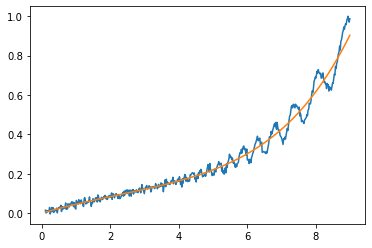

512 512


In [6]:
plt.figure()
feature, label = train_set[1]
x = np.linspace(0.1, 9, 512)
plt.plot(x, feature)
plt.plot(x, label)
plt.show()
print(len(label), len(feature))

In [7]:
class pa_poly(torch.autograd.Function):
    def forward(ctx, pa, x = torch.linspace(0.1, 9, 512)/9):
        ctx.n = len(pa[0])
        ctx.save_for_backward(pa)
        ctx.x = x
        my_out = []
        for ppa in pa:
            y = 0
            for i, p in enumerate(ppa):
                y += p * x.pow(ctx.n - i)
            my_out.append(y)
        return torch.stack(my_out)

    def backward(ctx, grad_out):
        input, = ctx.saved_tensors
        out = [torch.tensor([(grad_out * (ctx.n-i) * p * ctx.x.pow(ctx.n-i-1)).sum() for i, p in enumerate(pa)], requires_grad=True)
               for pa in input]
        out = torch.stack(out)
        return  out


class LK(nn.Module):
    def __init__(self, x_poly, order=6):
        super().__init__()
        self.order = order
        self.l1 = nn.Linear(512, 200)
        self.activation1 = torch.nn.Tanh()
        self.l2 = nn.Linear(200, order)
        self.activation2 = torch.nn.Tanh()
        self.f = pa_poly.apply

    def poly_pa(self, x):
        x = self.l1(x)
        x = self.activation1(x)
        x = self.l2(x)
        x = self.activation2(x)
        return x

    def forward(self, x):
        pa = self.poly_pa(x)
        y = self.f(pa)
        return y

x = np.linspace(0.1, 9, 512)
my_model = LK(x, order=6)

print('parameters:')
for pa in my_model.parameters():
    print(pa)

parameters:
Parameter containing:
tensor([[-0.0015,  0.0300, -0.0036,  ..., -0.0190,  0.0176, -0.0397],
        [ 0.0297,  0.0156,  0.0403,  ...,  0.0011, -0.0314, -0.0441],
        [-0.0074, -0.0427,  0.0025,  ..., -0.0187, -0.0211, -0.0139],
        ...,
        [ 0.0057,  0.0191,  0.0207,  ..., -0.0020,  0.0280, -0.0040],
        [ 0.0157, -0.0215,  0.0400,  ...,  0.0043,  0.0006,  0.0278],
        [ 0.0431,  0.0049,  0.0313,  ...,  0.0256,  0.0021, -0.0278]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0311,  0.0021, -0.0070, -0.0079,  0.0058,  0.0074, -0.0292, -0.0103,
        -0.0090, -0.0398,  0.0419,  0.0308, -0.0294, -0.0414, -0.0057,  0.0222,
        -0.0058,  0.0077, -0.0048, -0.0051, -0.0105,  0.0402, -0.0173,  0.0244,
         0.0050, -0.0377,  0.0003, -0.0103, -0.0306, -0.0086,  0.0350,  0.0196,
         0.0073, -0.0320, -0.0298, -0.0353, -0.0193,  0.0111, -0.0092,  0.0148,
         0.0347,  0.0436, -0.0290,  0.0109, -0.0412,  0.0439,  0.0085, -0.0132,
   

In [8]:
loss_fn = torch.nn.MSELoss()
feature, label = train_set[1]
outputs = label + 2

print(f'train label:\n{label}\n')
print(f'loss:\n{loss_fn(outputs, label)}')

train label:
tensor([0.0050, 0.0058, 0.0067, 0.0075, 0.0084, 0.0092, 0.0100, 0.0109, 0.0117,
        0.0125, 0.0134, 0.0142, 0.0150, 0.0158, 0.0166, 0.0174, 0.0183, 0.0191,
        0.0199, 0.0207, 0.0215, 0.0222, 0.0230, 0.0238, 0.0246, 0.0254, 0.0262,
        0.0269, 0.0277, 0.0285, 0.0293, 0.0300, 0.0308, 0.0315, 0.0323, 0.0331,
        0.0338, 0.0346, 0.0353, 0.0361, 0.0368, 0.0375, 0.0383, 0.0390, 0.0397,
        0.0405, 0.0412, 0.0419, 0.0427, 0.0434, 0.0441, 0.0448, 0.0455, 0.0463,
        0.0470, 0.0477, 0.0484, 0.0491, 0.0498, 0.0505, 0.0512, 0.0519, 0.0526,
        0.0533, 0.0540, 0.0547, 0.0554, 0.0561, 0.0568, 0.0574, 0.0581, 0.0588,
        0.0595, 0.0602, 0.0609, 0.0615, 0.0622, 0.0629, 0.0636, 0.0642, 0.0649,
        0.0656, 0.0662, 0.0669, 0.0676, 0.0682, 0.0689, 0.0696, 0.0702, 0.0709,
        0.0715, 0.0722, 0.0729, 0.0735, 0.0742, 0.0748, 0.0755, 0.0761, 0.0768,
        0.0774, 0.0781, 0.0787, 0.0794, 0.0800, 0.0807, 0.0813, 0.0820, 0.0826,
        0.0833, 0.0839, 0.0

In [9]:
optimizer = torch.optim.SGD(my_model.parameters(), lr=0.002, momentum=0.9)

In [10]:
def train_one_epoch(epoch_index, writer):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_loader):
        input, label = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        output = my_model(input)

        # Compute the loss and its gradients
        loss = loss_fn(output, label)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch

            loss_x = epoch_index * len(train_loader) + i + 1
            writer.add_scalar('Loss/train', last_loss, loss_x)

            running_loss = 0.

    return last_loss

In [11]:
from torch.utils.tensorboard import SummaryWriter
epoch_number = 0
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'../logs/{timestamp}')

epoch_number = 0
EPOCHS = 100

best_vloss = 1e-3

for epoch in range(EPOCHS):
    # Make sure gradient tracking is on, and do a pass over the data
    my_model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    my_model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata
        voutputs = my_model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    if epoch_number % 5 == 4:
        print(f'EPOCH {epoch_number + 1}:')
        print(f'LOSS train {avg_loss: .4f} valid {avg_vloss: .4f}')

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' :avg_loss, 'Validation': avg_vloss},
                    epoch_number + 1)
    writer.flush()

    epoch_number += 1
    if avg_loss < best_vloss:
        break

EPOCH 5:
LOSS train  0.9568 valid  0.9546
EPOCH 10:
LOSS train  0.9596 valid  0.9557
EPOCH 15:
LOSS train  0.9602 valid  0.9577
EPOCH 20:
LOSS train  0.9602 valid  0.9577
EPOCH 25:
LOSS train  0.9602 valid  0.9577
EPOCH 30:
LOSS train  0.9602 valid  0.9577
EPOCH 35:
LOSS train  0.9602 valid  0.9577
EPOCH 40:
LOSS train  0.9602 valid  0.9577
EPOCH 45:
LOSS train  0.9602 valid  0.9577
EPOCH 50:
LOSS train  0.9602 valid  0.9577
EPOCH 55:
LOSS train  0.9602 valid  0.9577
EPOCH 60:
LOSS train  0.9602 valid  0.9577
EPOCH 65:
LOSS train  0.9602 valid  0.9577
EPOCH 70:
LOSS train  0.9602 valid  0.9577
EPOCH 75:
LOSS train  0.9602 valid  0.9577
EPOCH 80:
LOSS train  0.9602 valid  0.9577
EPOCH 85:
LOSS train  0.9602 valid  0.9577
EPOCH 90:
LOSS train  0.9602 valid  0.9577
EPOCH 95:
LOSS train  0.9602 valid  0.9577
EPOCH 100:
LOSS train  0.9602 valid  0.9577


<ipython-input-12-375ea7fab892>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  feature, label = torch.Tensor([feature]), torch.Tensor([label])


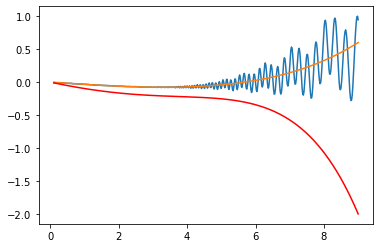

1 1


In [12]:
feature, a1, label, a2 = make_data(x, f_num=2, poly_order=6,
         rdio=[1, 2],f_range=[[50, 60],[150, 250]],
         m_range=[0.4, 0.8], t_range=[1, 2], td_range=[2, 4])
feature, label = torch.Tensor([feature]), torch.Tensor([label])
label_pre = my_model(feature)

plt.figure()
x = np.linspace(0.1, 9, 512)
plt.plot(x, feature[0])
plt.plot(x, label[0])
plt.plot(x, label_pre[0].detach().numpy(), c='r')
plt.show()
print(len(label), len(feature))

In [13]:
len(feature)


1